# Combine data sets

## 2018 Wildfire Events in Pullman, WA

> Patrick O'Keeffe  
> Laboratory for Atmospheric Research  
> Washington State University

In [1]:
import pandas as pd

from glob import glob
import os.path as osp

import numpy as np

In [2]:
%matplotlib inline

In [3]:
from bokeh.plotting import figure, show, output_file, reset_output, output_notebook
from bokeh.layouts import column
#from bokeh.resources import INLINE

from bokeh.palettes import brewer as palettes
output_notebook()

Loading BokehJS ...

In [4]:
def read_TOA5(fp, drop_record=True, fixup=False):
    """Read CSI TOA5-formatted file into `pandas.DataFrame`
    
    Params
    ------
    fp : str
        Path to source file
    drop_record : boolean, optional
        If `True` (default), discards record number column "RECORD"
    fixup : boolean, optional
        If `True`, enforces 'nice' time series characteristics
    
    Returns
    -------
    `pandas.DataFrame`

    """
    # Table 129 (p484) in CR1000 manual rev. 4/13/15
    # https://s.campbellsci.com/documents/us/manuals/cr1000.pdf
    ## HINT pandas csv parser will consume dbl-quotes around NANs
    csi_nans = ['NAN', -7999, 7999, 65535, 2147483647, -2147483648] #FIXME list should be data type specific
    
    df = pd.read_csv(fp,
                     index_col=0, # timestamps in first column
                     parse_dates=True, # iso8601
                     # explicit parser + coerce to prevent fallback to string-indexing
                     date_parser=lambda ts: pd.to_datetime(ts, 
                                                           format='%Y-%m-%d %H:%M:%S',
                                                           errors='coerce'),
                     header=1, # 1st line metadata 2nd headers
                     skiprows=[2,3], # 3rd units 4th agg type
                     na_values=csi_nans, keep_default_na=False # only recognize CSI NAN sentinels
                     )
    
    if drop_record:
        df.drop(['RECORD'], axis=1, errors='ignore', inplace=True)
    # HINT useful to fixup individual TOA5 files because LoggerNet will append to existing
    # files, including appending duplicate (re-downloaded) data rows
    if fixup:
         df = fixup_timeseries(df)
    return df

In [6]:
def fixup_timeseries(df, resample_how='mean', resample_freq='T'):
    """Enforce nice time-series characteristics: 
    
    * no duplicate rows
    * rows appear in temporal sequence
    * resampled to common time base (one minute)
    
    Params
    ------
    df : pandas.DataFrame
        Source dataframe
    resample_how : str or None, optional
        If not `None`, resamples to 1-min using specified method (default: mean)
    resample_freq : str or None, optional
        Specifies resample frequency to use if `resample_how` is not `None`
        (default: one minute)
        
    Returns
    -------
    `pandas.DataFrame`
    
    """
    if len(df.index.get_duplicates()):
        # HINT HACK chose `.last()` specifically to deal with incidence of
        # timestamps reverting to UTC (i.e. 8hrs ahead of "here" = PST/Z-0800)
        # in certain Campbell Scientific TOA5 files ... if timestamp does shift
        # into UTC it jumps forward in time so if dups occur, don't choose the
        # first one; this is a big hammer for a sporadic problem
        df = df.groupby(level=0).last()
    if not df.index.is_monotonic_increasing:
        df.sort_index(inplace=True)
    if resample_how is not None: 
        df = df.resample(resample_freq).agg(resample_how)
        
    return df

In [33]:
!ls

Combine datasets.ipynb
IAQ_INDOOR_012.csv
IAQ_INDOOR_013.csv
IAQ_OUTDOOR_026.csv
IAQ_OUTDOOR_027.csv
IMG_20180817_190506.jpg
IMG_20180820_114723.jpg
IMG_20180820_114805.jpg
IMG_20180820_114813.jpg
IMG_20180820_114903.jpg
IMG_20180820_114909.jpg
IMG_20180820_114924.jpg
IMG_20180820_114939.jpg
IMG_20180820_115018.jpg
IMG_20180821_132536.jpg
IMG_20180821_132558.jpg
IMG_20180821_132610.jpg
IMG_20180821_132620.jpg
PETB_smoke_20180820.xlsx
TOA5_lab-cr3000.dylos_20180820.dat
TOA5_lab-cr3000.dylos_20180823.dat
readme.md


### Dylos DC1100 units

In [146]:
dc_aug17 = read_TOA5('TOA5_lab-cr3000.dylos_20180817.dat')

# FIXUP adjust clocks per synchronization on Aug 20 --> adjust backwards 2min
dc_aug17 = dc_aug17.tshift(periods=-2, freq='T')

In [147]:
dc_aug20 = read_TOA5('TOA5_lab-cr3000.dylos_20180820.dat')

In [148]:
dc_aug23 = read_TOA5('TOA5_lab-cr3000.dylos_20180823.dat')

In [152]:
dc = fixup_timeseries(pd.concat([dc_aug17, dc_aug20, dc_aug23]))

When DC1100 fails to communicate, logger holds previous value in memory and mistakenly retains as current measurement. For each unit, look for both small and large values to fail to change, and if any occurrences are found replace values with NAN.

In [153]:
occurrences = ((dc.dc1100_A_pm_large.tshift(1) - dc.dc1100_A_pm_large == 0) & 
               (dc.dc1100_A_pm_small.tshift(1) - dc.dc1100_A_pm_small == 0)   )

dc.dc1100_A_pm_large[occurrences] = np.nan
dc.dc1100_A_pm_small[occurrences] = np.nan

In [154]:
occurrences = ((dc.dc1100_B_pm_large.tshift(1) - dc.dc1100_B_pm_large == 0) & 
               (dc.dc1100_B_pm_small.tshift(1) - dc.dc1100_B_pm_small == 0)   )

dc.dc1100_B_pm_large[occurrences] = np.nan
dc.dc1100_B_pm_small[occurrences] = np.nan

In [156]:
dc

,dc1100_A_pm_small,dc1100_A_pm_large,dc1100_B_pm_small,dc1100_B_pm_large
TIMESTAMP,,,,
2018-08-17 18:11:00,632.0,62.0,333.0,39.0
2018-08-17 18:12:00,NaN,NaN,471.0,90.0
2018-08-17 18:13:00,NaN,NaN,341.0,41.0
2018-08-17 18:14:00,NaN,NaN,315.0,36.0
2018-08-17 18:15:00,NaN,NaN,328.0,37.0
2018-08-17 18:16:00,NaN,NaN,298.0,31.0
2018-08-17 18:17:00,NaN,NaN,330.0,40.0
2018-08-17 18:18:00,NaN,NaN,328.0,44.0
2018-08-17 18:19:00,NaN,NaN,321.0,41.0


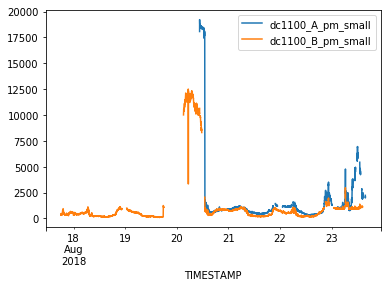

In [157]:
dc[['dc1100_A_pm_small', 'dc1100_B_pm_small']].plot()

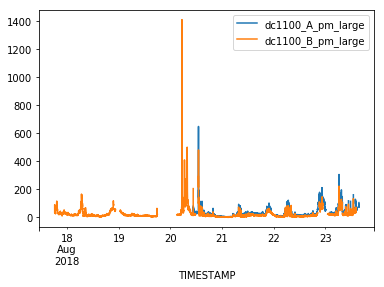

In [158]:
dc[['dc1100_A_pm_large', 'dc1100_B_pm_large']].plot()

### DustTrak II units

In [159]:
from io import StringIO
def read_DustTrak8530_export_csv(fp):
    """Read DustTrak 8530 direct export file into `pandas.DataFrame`

    Params
    ------
    fp : str
        Source file path
    
    Returns
    -------
    `pandas.DataFrame`
    """
    hstr, bstr = '', ''
    with open(fp) as f:
        # extract file header
        for line in range(1,20):
            hstr += f.readline()
            #print(line, ' ', f.readline().strip())
        # ingest rest of file as dataset
        bstr = f.read()
    
    header = pd.read_csv(StringIO(hstr)).set_index('Instrument Name')
    start_date = header.loc['Test Start Date']['DustTrak II']
    start_time = header.loc['Test Start Time']['DustTrak II']
    start_offset = pd.to_datetime(start_date) + pd.to_timedelta(start_time)
    
    df = pd.read_csv(StringIO(bstr))
    df['Timestamp'] = start_offset + pd.to_timedelta(df['Elapsed Time [s]'], unit='s')
    df.set_index('Timestamp', inplace=True)
    df.drop('Elapsed Time [s]', axis=1, inplace=True)
    
    ## HINT data runs begun on the hour with 2-min logging interval will stamp
    ##      first data point with `:02` so to achieve "closed=left, label=left"
    ##      convention, specify 2-min label offset (`loffset`)
    ## HINT specify forward-fill limit of 1 row when upsampling to prevent
    ##      inadvertent gap filling
    df = df.resample('T', loffset='-2T').mean().ffill(limit=1)
    return df

#### Outdoor unit

In [160]:
dt1_aug17 = read_DustTrak8530_export_csv('IAQ_OUTDOOR_026.csv')

In [161]:
dt1_aug20 = read_DustTrak8530_export_csv('IAQ_OUTDOOR_027.csv')

In [163]:
dt1 = pd.concat([unit1_aug17, unit1_aug20])
dt1

,Mass [mg/m3],Alarms,Errors
Timestamp,,,
2018-08-17 16:19:00,0.009,NaN,NaN
2018-08-17 16:20:00,0.009,NaN,NaN
2018-08-17 16:21:00,0.010,NaN,NaN
2018-08-17 16:22:00,0.010,NaN,NaN
2018-08-17 16:23:00,0.010,NaN,NaN
2018-08-17 16:24:00,0.010,NaN,NaN
2018-08-17 16:25:00,0.010,NaN,NaN
2018-08-17 16:26:00,0.010,NaN,NaN
2018-08-17 16:27:00,0.010,NaN,NaN


#### Indoor unit

In [164]:
dt2_aug17 = read_DustTrak8530_export_csv('IAQ_INDOOR_012.csv')

# FIXUP compensate for lagging clock
dt2_aug17 = unit2_aug17.tshift(periods=2, freq='T')

In [165]:
dt2_aug20 = read_DustTrak8530_export_csv('IAQ_INDOOR_013.csv')

In [166]:
dt2 = pd.concat([unit2_aug17, unit2_aug20])
dt2

,Mass [mg/m3],Alarms,Errors
Timestamp,,,
2018-08-17 16:23:00,0.069,NaN,NaN
2018-08-17 16:24:00,0.069,NaN,NaN
2018-08-17 16:25:00,0.011,NaN,NaN
2018-08-17 16:26:00,0.011,NaN,NaN
2018-08-17 16:27:00,0.010,NaN,NaN
2018-08-17 16:28:00,0.010,NaN,NaN
2018-08-17 16:29:00,0.010,NaN,NaN
2018-08-17 16:30:00,0.010,NaN,NaN
2018-08-17 16:31:00,0.010,NaN,NaN


In [167]:
dt1['Mass [mg/m3]'].rename('foo')

Timestamp
2018-08-17 16:19:00    0.009
2018-08-17 16:20:00    0.009
2018-08-17 16:21:00    0.010
2018-08-17 16:22:00    0.010
2018-08-17 16:23:00    0.010
2018-08-17 16:24:00    0.010
2018-08-17 16:25:00    0.010
2018-08-17 16:26:00    0.010
2018-08-17 16:27:00    0.010
2018-08-17 16:28:00    0.010
2018-08-17 16:29:00    0.010
2018-08-17 16:30:00    0.010
2018-08-17 16:31:00    0.010
2018-08-17 16:32:00    0.010
2018-08-17 16:33:00    0.010
2018-08-17 16:34:00    0.010
2018-08-17 16:35:00    0.009
2018-08-17 16:36:00    0.009
2018-08-17 16:37:00    0.009
2018-08-17 16:38:00    0.009
2018-08-17 16:39:00    0.010
2018-08-17 16:40:00    0.010
2018-08-17 16:41:00    0.010
2018-08-17 16:42:00    0.010
2018-08-17 16:43:00    0.009
2018-08-17 16:44:00    0.009
2018-08-17 16:45:00    0.009
2018-08-17 16:46:00    0.009
2018-08-17 16:47:00    0.010
2018-08-17 16:48:00    0.010
                       ...  
2018-08-23 08:28:00    0.052
2018-08-23 08:29:00    0.053
2018-08-23 08:30:00    0.053
2018

In [168]:
df = pd.concat([dc, 
                dt1['Mass [mg/m3]'].rename('DustTrak_unit1_pm25'),
                dt1['Mass [mg/m3]'].rename('DustTrak_unit2_pm25')],
               axis=1)

In [172]:
df.to_excel('data.xlsx')